# Notebook 1: Generating the neutral hydrogen map

The following code generates a hydrogen map from theory:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from meer21cm import MockSimulation
from meer21cm.plot import plot_map

In [2]:
# this is for saving plots?
import os

# this is for the multiprocessing but works with Jupyter notebooks
from joblib import Parallel, delayed

# this is to create a progress bar when running code 
from tqdm import tqdm
import time

In [3]:
def save_project_plot(fig, week_number, filename):
    """
    Saves a matplotlib figure to a specific week's folder.
    Example: week_number=1 saves to .../outputs/week1/
    """
    # 1. Define the base path
    base_path = "/Users/gracetait/shproject/senior_honours_project/outputs"
    
    # 2. Create the week-specific folder name
    week_folder = f"week{week_number}"
    
    # 3. Combine them into a full path
    target_dir = os.path.join(base_path, week_folder)
    
    # 4. Create the directory if it doesn't exist yet
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created new directory: {target_dir}")
    
    # 5. Define the final file path
    save_path = os.path.join(target_dir, filename)
    
    # 6. Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Successfully saved: {save_path}")

In [4]:
mock = MockSimulation(
    survey='meerklass_2021',
    band='L',
    ra_range=(334, 357),
    dec_range=(-35, -26.5),
    flat_sky=True,
    seed=42,
)


This gives you a survey area and the frequency range. This is the survey area:

Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/empty_hydrogen_map.pdf


<Figure size 640x480 with 0 Axes>

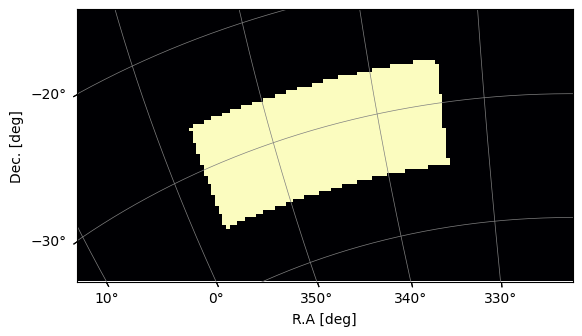

In [5]:
save_project_plot(plt.gcf(), week_number = 1, filename = "empty_hydrogen_map.pdf")
plot_map(mock.W_HI, mock.wproj, have_cbar=False)

And the frequency range gives you the cosmological redshifts:

Text(0, 0.5, 'Redshift')

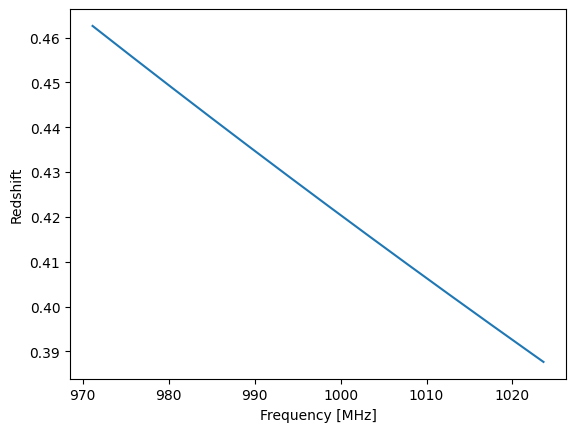

In [6]:
plt.plot(mock.nu/1e6, mock.z_ch)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Redshift')

And let us define some input model for the cosmological neutral hydrogen distribution:

In [7]:
mock.omega_hi = 5e-4 # neutral hydrogen fraction
mock.mean_amp_1 = 'average_hi_temp'
mock.tracer_bias_1 = 1.0 # bias of the neutral hydrogen distribution relative to the dark matter distribution


In [8]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)

Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/hydrogen_map.pdf


<Figure size 640x480 with 0 Axes>

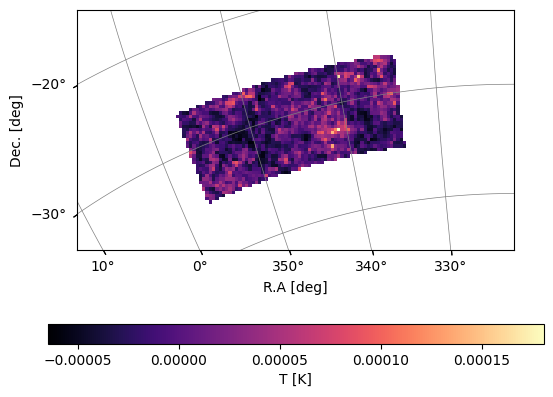

In [9]:
save_project_plot(plt.gcf(), week_number = 1, filename = "hydrogen_map.pdf")
plot_map(mock.data, mock.wproj, W=mock.W_HI,have_cbar=True,cbar_label='T [K]')

Note that, this does not reflect the real observation. A real observation would include the telescope beam smoothing, foreground contamination, thermal noise and more potential systematics. For now, let us keep it simple and stick to just a 21cm signal.

## Power Spectrum
What we want to extract from the map is the power spectrum. It tells us how matter distributes in the Universe. From a theory perspective, the power spectrum is a function of ($k_\perp$, $k_\parallel$) 

In [10]:
mock.grid_data_to_field();

In [11]:
mock.kparabins = np.linspace(0, 1, 11)
mock.kperpbins = np.linspace(0, 0.5, 21)
power_cy,_ = mock.get_cy_power(mock.auto_power_3d_1)

Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/power_spectrum_from_hydrogen_map.pdf


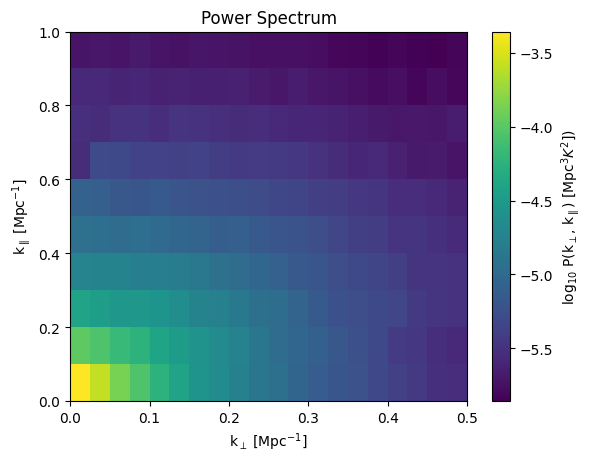

In [12]:
plt.pcolormesh(mock.kperpbins, mock.kparabins, np.log10(power_cy.T))
cbar = plt.colorbar()
cbar.set_label(r'log$_{10}$ P(k$_\perp$, k$_\parallel$) [${\rm Mpc}^{3}K^2]$)')
plt.xlabel('k$_\perp$ [Mpc$^{-1}$]')
plt.ylabel('k$_\parallel$ [Mpc$^{-1}$]')
plt.title('Power Spectrum')
save_project_plot(plt.gcf(), week_number = 1, filename = "power_spectrum_from_hydrogen_map.pdf")
plt.show()


In practice, we average the power spectrum into a 1D spectrum:

In [13]:
mock.k1dbins = np.linspace(0, 1.2, 21)
power_1d,k_1d,nmodes_1d = mock.get_1d_power(mock.auto_power_3d_1)

And let us compare with the input theory:

In [14]:
power_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)


Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/1D_power_spectrum_neutral_hydrogen_map_1_realisations.pdf


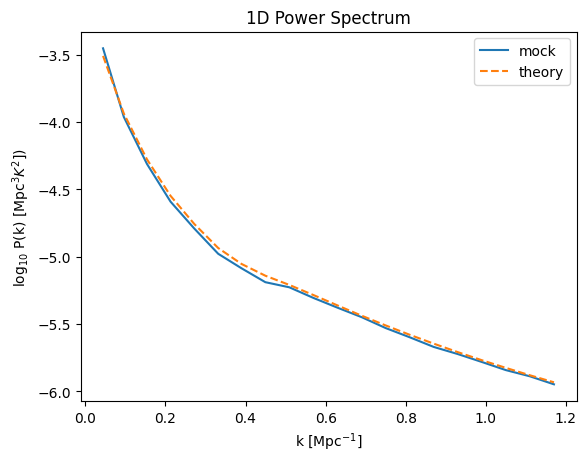

In [15]:
plt.plot(k_1d, np.log10(power_1d.T),label='mock')
plt.plot(k_1d, np.log10(power_model.T),label='theory',ls='--')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'log$_{10}$ P(k) [${\rm Mpc}^{3}K^2]$)')
plt.title('1D Power Spectrum')
plt.legend()
save_project_plot(plt.gcf(), week_number = 1, filename = "1D_power_spectrum_neutral_hydrogen_map_1_realisations.pdf")

plt.show()



Task for you: If you go back to the beginning of the notebook, you can see that I specify `seed=42`. This is to say we use a fixed seed for random number generation, which gives you **one realization** of the mock. In order to put error bars on the blue line above, we need to change this seed to run multiple realizations. Organise the code snippets above into a function, that takes seed number as an input. Run 100 realisations and take the standard deviation of the 100 realizations as the error bar. Try it first yourself, don't worry if you can't finish it in time and we can go through this next week.

In [16]:
def generate_neutral_hydrogen_map(seed):

    # check if seed is an integer
    if not isinstance(seed, (int, np.integer)):
        
        print("Error: The seed must be an integer.")
        return
    
    # generate a hydrogen map from theory
    # this gives a survey area and the frequency range
    # the frequency range gies the cosmological redshifts
    mock = MockSimulation(
    survey='meerklass_2021',
    band='L',
    ra_range=(334, 357),
    dec_range=(-35, -26.5),
    flat_sky=True,
    seed=seed,
    )

    # define some input model for the cosmological neutral hydrogen distribution
    mock.omega_hi = 5e-4 # neutral hydrogen fraction
    mock.mean_amp_1 = 'average_hi_temp'
    mock.tracer_bias_1 = 1.0 # bias of the neutral hydrogen distribution relative to the dark matter distribution

    # this does not reflect the real observation, just the 21cm signal
    mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)

    # extract from the map the power spectrum (tells us the matter distribution in the Universe)
    mock.grid_data_to_field();

    mock.kparabins = np.linspace(0, 1, 11)
    mock.kperpbins = np.linspace(0, 0.5, 21)
    power_cy,_ = mock.get_cy_power(mock.auto_power_3d_1)

    # average the power spectrum into a 1D spectrum
    mock.k1dbins = np.linspace(0, 1.2, 21)
    power_1d,k_1d,nmodes_1d = mock.get_1d_power(mock.auto_power_3d_1)

    # compare with the input theory
    power_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)

    # rename values
    mock_power_1d = np.log10(power_1d.T)
    theory_power_1d = np.log10(power_model.T)

    return k_1d, mock_power_1d, theory_power_1d


In [17]:
# This is a loop that calls the function above and prints out a message for each iteration of the loop it is in
# The message is quite long so I found another way to track the progress
"""
# generate a list of 100 integers [0, 1, 2, ..., 99]
seeds = np.arange(1, 101)

# create empty arrays to store data
k_1d_list = []
mock_power_1d_list = []
theory_power_1d_list = []

# iterate through the seeds array to run 100 realizations
for i in range(len(seeds)):
    
    # print iteration of loop
    print(f"Running realisation {i} ...")
    
    # obtain power spectrum data from function using a a seed
    k_1d, mock_power_1d, theory_power_1d = generate_neutral_hydrogen_map(seeds[i])

    # append data to lists
    k_1d_list.append(k_1d)
    mock_power_1d_list.append(mock_power_1d)
    theory_power_1d_list.append(theory_power_1d)

# take the means of the 100 realisations
k_1d_list_mean = np.mean(k_1d_list, axis = 0)
mock_power_1d_mean = np.mean(mock_power_1d_list, axis = 0)
theory_power_1d_mean = np.mean(theory_power_1d_list, axis = 0)

# take the standard deviations of the 100 realisations
k_1d_list_std = np.std(k_1d_list, axis = 0)
mock_power_1d_std = np.std(mock_power_1d_list, axis = 0)
theory_power_1d_std = np.std(theory_power_1d_list, axis = 0)
"""

'\n# generate a list of 100 integers [0, 1, 2, ..., 99]\nseeds = np.arange(1, 101)\n\n# create empty arrays to store data\nk_1d_list = []\nmock_power_1d_list = []\ntheory_power_1d_list = []\n\n# iterate through the seeds array to run 100 realizations\nfor i in range(len(seeds)):\n    \n    # print iteration of loop\n    print(f"Running realisation {i} ...")\n    \n    # obtain power spectrum data from function using a a seed\n    k_1d, mock_power_1d, theory_power_1d = generate_neutral_hydrogen_map(seeds[i])\n\n    # append data to lists\n    k_1d_list.append(k_1d)\n    mock_power_1d_list.append(mock_power_1d)\n    theory_power_1d_list.append(theory_power_1d)\n\n# take the means of the 100 realisations\nk_1d_list_mean = np.mean(k_1d_list, axis = 0)\nmock_power_1d_mean = np.mean(mock_power_1d_list, axis = 0)\ntheory_power_1d_mean = np.mean(theory_power_1d_list, axis = 0)\n\n# take the standard deviations of the 100 realisations\nk_1d_list_std = np.std(k_1d_list, axis = 0)\nmock_power_1d_

In [18]:
# generate a list of 100 integers [1, 2, 3, ..., 100]
seeds = np.arange(1, 101)

# create empty arrays to store data
k_1d_list = []
mock_power_1d_list = []
theory_power_1d_list = []

# iterate through the seeds array to run 100 realizations with progress bar
for i in tqdm(range(len(seeds)), desc="Processing seeds"):
    
    # obtain power spectrum data from function using a seed
    k_1d, mock_power_1d, theory_power_1d = generate_neutral_hydrogen_map(seeds[i])
    
    # append data to lists
    k_1d_list.append(k_1d)
    mock_power_1d_list.append(mock_power_1d)
    theory_power_1d_list.append(theory_power_1d)

# take the means of the 100 realisations
k_1d_list_mean = np.mean(k_1d_list, axis=0)
mock_power_1d_mean = np.mean(mock_power_1d_list, axis=0)
theory_power_1d_mean = np.mean(theory_power_1d_list, axis=0)

# take the standard deviations of the 100 realisations
k_1d_list_std = np.std(k_1d_list, axis=0)
mock_power_1d_std = np.std(mock_power_1d_list, axis=0)
theory_power_1d_std = np.std(theory_power_1d_list, axis=0)

Processing seeds: 100%|███████████████████████| 100/100 [03:05<00:00,  1.85s/it]


NameError: name 'k_1d_std' is not defined

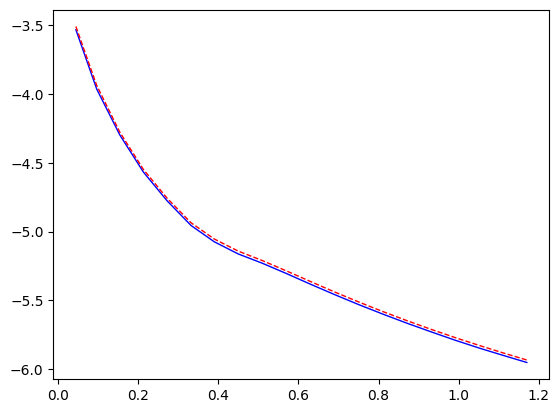

In [21]:
# plot the 1D power spectrum
plt.plot(k_1d_list_mean, mock_power_1d_mean, label='mock', color = 'blue', linewidth = 1)
plt.plot(k_1d_list_mean, theory_power_1d_mean, label='theory',ls='--', color = 'red', linewidth = 1)
plt.errorbar(k_1d_list_mean, mock_power_1d_mean, yerr = mock_power_1d_std, xerr = k_1d_std, fmt = 'o', capsize = 3, color = 'blue', markersize = 1, linewidth = 1)
plt.errorbar(k_1d_list_mean, theory_power_1d_mean, yerr = theory_power_1d_std, xerr = k_1d_std, fmt = 'None', capsize = 3, color = 'red', markersize = 1, linewidth = 1)

# add title and labels
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'log$_{10}$ P(k) [${\rm Mpc}^{3}K^2]$)')
plt.title('1D Power Spectrum')
plt.legend()

# save plot to outputs file
# use plt.gcf() to grab the plot
save_project_plot(plt.gcf(), week_number = 1, filename = "1D_power_spectrum_neutral_hydrogen_map_100_realisations.pdf")

# show plot
plt.show()

In [22]:
# generate a list of 100 integers [1, 2, 3, ..., 100]
seeds = np.arange(1, 101)

# determine number of processes
num_processes = os.cpu_count()

print(f"Running with {num_processes} processes...")
start_time = time.time()

# run in parallel with progress bar
results = Parallel(n_jobs=num_processes)(
    delayed(generate_neutral_hydrogen_map)(seed) 
    for seed in tqdm(seeds, desc="Processing seeds"))

# calculate elapsed time
elapsed_time = time.time() - start_time
print(f"\nTotal time: {elapsed_time/60:.2f} minutes ({elapsed_time:.2f} seconds)")

# unpack results
k_1d_list = [result[0] for result in results]
mock_power_1d_list = [result[1] for result in results]
theory_power_1d_list = [result[2] for result in results]

# take the means of the 100 realisations
k_1d_mean = np.mean(k_1d_list, axis=0)
mock_power_1d_mean = np.mean(mock_power_1d_list, axis=0)
theory_power_1d_mean = np.mean(theory_power_1d_list, axis=0)

# take the standard deviations of the 100 realisations
k_1d_std = np.std(k_1d_list, axis=0)
mock_power_1d_std = np.std(mock_power_1d_list, axis=0)
theory_power_1d_std = np.std(theory_power_1d_list, axis=0)

Running with 8 processes...


Processing seeds: 100%|███████████████████████| 100/100 [01:04<00:00,  1.56it/s]



Total time: 1.29 minutes (77.22 seconds)


Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/1D_power_spectrum_neutral_hydrogen_map_100_realisations.pdf


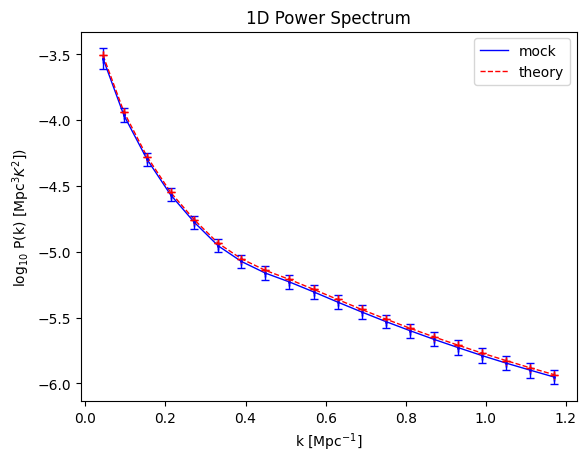

In [23]:
# plot the 1D power spectrum
plt.plot(k_1d_list_mean, mock_power_1d_mean, label='mock', color = 'blue', linewidth = 1)
plt.plot(k_1d_list_mean, theory_power_1d_mean, label='theory',ls='--', color = 'red', linewidth = 1)
plt.errorbar(k_1d_mean, mock_power_1d_mean, yerr = mock_power_1d_std, xerr = k_1d_std, fmt = 'o', capsize = 3, color = 'blue', markersize = 1, linewidth = 1)
plt.errorbar(k_1d_mean, theory_power_1d_mean, yerr = theory_power_1d_std, xerr = k_1d_std, fmt = 'None', capsize = 3, color = 'red', markersize = 1, linewidth = 1)

# add title and labels
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'log$_{10}$ P(k) [${\rm Mpc}^{3}K^2]$)')
plt.title('1D Power Spectrum')
plt.legend()

# save plot to outputs file
# use plt.gcf() to grab the plot
save_project_plot(plt.gcf(), week_number = 1, filename = "1D_power_spectrum_neutral_hydrogen_map_100_realisations.pdf")

# show plot
plt.show()